In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
from collections import Counter

import tensorflow as tf
import ast 
import re
from tqdm import tqdm
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

2025-03-15 12:12:45.454749: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 12:12:45.701607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742040765.796373   51874 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742040765.825769   51874 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 12:12:46.069108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
wav_song_path = "IsoDatasetPro/Songs/"
IsoDatasetPro = "IsoDatasetPro/"
standardized_file = "IsoDatasetPro/Standardized"
chord_vocab_file = "IsoDatasetPro/chord_vocabulary_12_keys.csv"
train_file = "IsoDatasetPro/train.csv"
test_file = "IsoDatasetPro/test.csv"
validation_file = "IsoDatasetPro/validation.csv"

# Dataset Expansion
exp_song_path = "IsoDatasetPro/Expanded/Songs"
exp_file_path = "IsoDatasetPro/Expanded/Files"


In [3]:
# Define categories (merging 'X' into 'N')
roots = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'N', 'X']
basses = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'N', 'X']
triads = ['Major', 'Minor', 'Diminished', 'Augmented', 'Sus2', 'Sus4', 'N', 'X']
fourths = ['dim7', 'min7', 'maj7', 'maj6', 'N', 'X']

In [4]:
standardized_file = exp_file_path
wav_song_path = exp_song_path

Processing sample: 01_01_(-1).csv
Processing sample: 01_01_(-2).csv
Processing sample: 01_01_(-3).csv
Processing sample: 01_01_(0).csv
Processing sample: 01_01_(1).csv
Processing sample: 01_01_(2).csv
Processing sample: 01_01_(3).csv
Processing sample: 01_02_(-1).csv
Processing sample: 01_02_(-2).csv
Processing sample: 01_02_(-3).csv
Processing sample: 01_02_(0).csv
Processing sample: 01_02_(1).csv
Processing sample: 01_02_(2).csv
Processing sample: 01_02_(3).csv
Processing sample: 01_03_(-1).csv
Processing sample: 01_03_(-2).csv
Processing sample: 01_03_(-3).csv
Processing sample: 01_03_(0).csv
Processing sample: 01_03_(1).csv
Processing sample: 01_03_(2).csv
Processing sample: 01_03_(3).csv
Processing sample: 01_04_(-1).csv
Processing sample: 01_04_(-2).csv
Processing sample: 01_04_(-3).csv
Processing sample: 01_04_(0).csv
Processing sample: 01_04_(1).csv
Processing sample: 01_04_(2).csv
Processing sample: 01_04_(3).csv
Processing sample: 01_05_(-1).csv
Processing sample: 01_05_(-2).

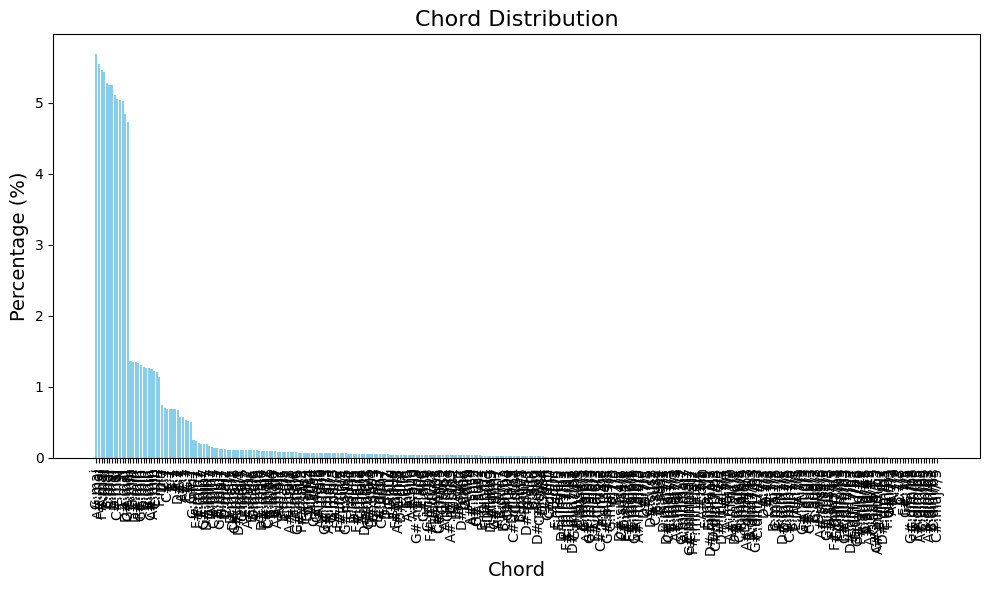

In [5]:
# Dictionary to store chord counts
chord_counts = Counter()
total_chords = 0

# Loop through each sample folder
for file in os.listdir(standardized_file):
    print(f"Processing sample: {file}")
    
    combined_file = os.path.join(standardized_file, file)
    
    if os.path.exists(combined_file):
        df = pd.read_csv(combined_file)
    
        # Count chords in this file
        chord_counts.update(df['Chord_Label'])
        total_chords += len(df['Chord_Label'])

# Calculate percentages for unique chords
chord_percentages = {chord: (count / total_chords) * 100 for chord, count in chord_counts.items()}

# Convert to DataFrame for better readability
chord_distribution_df = pd.DataFrame(list(chord_percentages.items()), columns=['Chord', 'Percentage'])

# Add chord counts to the DataFrame
chord_distribution_df['Chord_Count'] = chord_distribution_df['Chord'].map(chord_counts)

# Sort by percentage (descending)
chord_distribution_df = chord_distribution_df.sort_values(by='Percentage', ascending=False)

print(chord_distribution_df)

# Plotting the chord distribution
plt.figure(figsize=(10, 6))
plt.bar(chord_distribution_df['Chord'], chord_distribution_df['Percentage'], color='skyblue')

# Adding labels and title
plt.xlabel('Chord', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Chord Distribution', fontsize=16)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

In [6]:
# Calculate the rare chord threshold
rare_threshold = (0.1 / chord_distribution_df['Percentage'].sum()) * 100

# Identify rare chords based on the threshold
rare_chords = chord_distribution_df[chord_distribution_df["Percentage"] < rare_threshold]['Chord'].tolist()
non_rare_chords = chord_distribution_df[chord_distribution_df["Percentage"] >= rare_threshold]['Chord'].tolist()

print(f"🔍 Identified {len(rare_chords)} rare chords:")
print(rare_chords)

🔍 Identified 259 rare chords:
['C:maj6', 'D#:maj6', 'F#:maj7', 'C#:maj7', 'C#:maj6', 'B:maj6', 'B:maj7', 'A#:maj7', 'A:maj7', 'E:maj/5', 'F:maj/5', 'C:maj7', 'A#:maj/5', 'E:maj6', 'F:maj6', 'G#:maj/5', 'F#:maj/5', 'F#:sus4', 'E:min/5', 'G:sus4', 'A:sus4', 'G#:sus4', 'G:maj/5', 'A:maj6', 'A#:maj6', 'G#:maj/3', 'G:maj/3', 'A#:maj/3', 'G:min/5', 'A:maj/3', 'F#:maj6', 'F#:min/5', 'E:sus4', 'G#:min/5', 'F:sus4', 'F:min/5', 'D:min/5', 'F#:maj/3', 'E:maj/3', 'G:maj6', 'D#:min/5', 'F:maj/3', 'G#:maj6', 'D#:sus4', 'C:maj/3', 'B:maj/3', 'C:dim7', 'C#:dim7', 'D:dim7', 'F:dim7', 'G:aug', 'F#:aug', 'F#:dim7', 'A#:min/5', 'D#:dim', 'E:dim', 'F:dim', 'A:min/5', 'A:aug', 'A#:aug', 'G#:min/b3', 'F:aug', 'E:aug', 'G#:dim', 'G:min/b3', 'F#:min/b3', 'E:dim7', 'F#:sus2', 'C#:min/5', 'C#:maj/3', 'G:sus2', 'A:min/b3', 'G#:aug', 'A#:min/b3', 'C:sus2', 'F#:dim', 'B:sus2', 'D#:dim7', 'D:aug', 'G:dim', 'A:dim', 'A#:sus4', 'A#:sus2', 'G#:sus2', 'A:sus2', 'E:min/b3', 'F:min/b3', 'D#:aug', 'D:min/b3', 'A:dim7', 'G#

In [7]:
# Step 1: Collecting song data and chord info
song_to_chords = defaultdict(set)  # Mapping from song ID to chords
chord_to_songs = defaultdict(set)  # Mapping from chord to song IDs

# Loop through each sample file in the directory
for file in os.listdir(standardized_file):
    if file.endswith(".csv"):  # Ensure only CSV files are processed
        print(f"Processing sample: {file}")
        
        # Get song ID from file name (without extension)
        song_id = os.path.splitext(file)[0]
        combined_file = os.path.join(standardized_file, file)
        
        if os.path.exists(combined_file):
            df = pd.read_csv(combined_file)
            
            # Extract the unique chord labels for this song
            unique_chords = set(df['Chord_Label'].unique())
            
            # Store song → chords mapping
            song_to_chords[song_id] = unique_chords

            # Store chord → songs mapping
            for chord in unique_chords:
                chord_to_songs[chord].add(song_id)

print(f"🎯 {len(song_to_chords)} songs and {len(chord_to_songs)} unique chords found.")

# Start with rare chord songs (so they are included in all splits)
rare_songs = {song for chord in rare_chords for song in chord_to_songs[chord]}
print(f"🎯 {len(rare_songs)} songs contain rare chords.")


Processing sample: 01_01_(-1).csv
Processing sample: 01_01_(-2).csv
Processing sample: 01_01_(-3).csv
Processing sample: 01_01_(0).csv
Processing sample: 01_01_(1).csv
Processing sample: 01_01_(2).csv
Processing sample: 01_01_(3).csv
Processing sample: 01_02_(-1).csv
Processing sample: 01_02_(-2).csv
Processing sample: 01_02_(-3).csv
Processing sample: 01_02_(0).csv
Processing sample: 01_02_(1).csv
Processing sample: 01_02_(2).csv
Processing sample: 01_02_(3).csv
Processing sample: 01_03_(-1).csv
Processing sample: 01_03_(-2).csv
Processing sample: 01_03_(-3).csv
Processing sample: 01_03_(0).csv
Processing sample: 01_03_(1).csv
Processing sample: 01_03_(2).csv
Processing sample: 01_03_(3).csv
Processing sample: 01_04_(-1).csv
Processing sample: 01_04_(-2).csv
Processing sample: 01_04_(-3).csv
Processing sample: 01_04_(0).csv
Processing sample: 01_04_(1).csv
Processing sample: 01_04_(2).csv
Processing sample: 01_04_(3).csv
Processing sample: 01_05_(-1).csv
Processing sample: 01_05_(-2).

In [8]:
# Specify the ratio for each split
train_ratio = 0.75
val_ratio = 0.125
test_ratio = 0.125

In [9]:
# Initialize the sets for the splits
train_songs = set()
val_songs = set()
test_songs = set()

# Store the total number of songs
total_songs = len(song_to_chords)

# Store which chords are in each split
chord_splits = {chord: {'train': False, 'val': False, 'test': False} for chord in unique_chords}

# For rare chords, distribute their songs across splits
for chord in rare_chords:
    songs_with_chord = list(chord_to_songs[chord])

    if len(songs_with_chord) == 1:
        # If only one song with this chord, add to all splits
        for split in [train_songs, val_songs, test_songs]:
            if songs_with_chord[0] not in split:
                split.add(songs_with_chord[0])
    elif len(songs_with_chord) == 2:
        # If only two songs, assign one to train/val, other to test
        if songs_with_chord[0] not in train_songs and len(train_songs) / total_songs < train_ratio:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs and len(val_songs) / total_songs < val_ratio:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[1] not in test_songs and len(test_songs) / total_songs < test_ratio:
            test_songs.add(songs_with_chord[1])
    elif len(songs_with_chord) == 3:
        # If three songs, assign one to each split
        if songs_with_chord[0] not in train_songs:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[2] not in test_songs:
            test_songs.add(songs_with_chord[2])
    else:
        # More than three songs, check and assign before shuffling
        # Avoid duplicating songs in the splits
        available_splits = {
            'train': train_songs,
            'val': val_songs,
            'test': test_songs
        }

        # Add the first available songs to the splits if they don't already exist
        for idx, song in enumerate(songs_with_chord[:3]):
            if song not in train_songs and available_splits['train'] != train_songs:
                train_songs.add(song)
            elif song not in val_songs and available_splits['val'] != val_songs:
                val_songs.add(song)
            elif song not in test_songs and available_splits['test'] != test_songs:
                test_songs.add(song)

        # Shuffle the remaining songs and assign them based on proportions
        np.random.shuffle(songs_with_chord[3:])
        remaining_songs = songs_with_chord[3:]

        for song in remaining_songs:
            if song not in train_songs and len(train_songs) / total_songs < train_ratio:
                train_songs.add(song)
            elif song not in val_songs and len(val_songs) / total_songs < val_ratio:
                val_songs.add(song)
            elif song not in test_songs and len(test_songs) / total_songs < test_ratio:
                test_songs.add(song)

# For non-rare chords, distribute their songs across splits
for chord in non_rare_chords:
    songs_with_chord = list(chord_to_songs[chord])

    if len(songs_with_chord) == 1:
        # If only one song with this chord, add to all splits
        for split in [train_songs, val_songs, test_songs]:
            if songs_with_chord[0] not in split:
                split.add(songs_with_chord[0])
    elif len(songs_with_chord) == 2:
        # If only two songs, assign one to train/val, other to test
        if songs_with_chord[0] not in train_songs and len(train_songs) / total_songs < train_ratio:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs and len(val_songs) / total_songs < val_ratio:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[1] not in test_songs and len(test_songs) / total_songs < test_ratio:
            test_songs.add(songs_with_chord[1])
    elif len(songs_with_chord) == 3:
        # If three songs, assign one to each split
        if songs_with_chord[0] not in train_songs:
            train_songs.add(songs_with_chord[0])
        if songs_with_chord[1] not in val_songs:
            val_songs.add(songs_with_chord[1])
        if songs_with_chord[2] not in test_songs:
            test_songs.add(songs_with_chord[2])
    else:
        # More than three songs, check and assign before shuffling
        # Avoid duplicating songs in the splits
        available_splits = {
            'train': train_songs,
            'val': val_songs,
            'test': test_songs
        }

        # Add the first available songs to the splits if they don't already exist
        for idx, song in enumerate(songs_with_chord[:3]):
            if song not in train_songs and available_splits['train'] != train_songs:
                train_songs.add(song)
            elif song not in val_songs and available_splits['val'] != val_songs:
                val_songs.add(song)
            elif song not in test_songs and available_splits['test'] != test_songs:
                test_songs.add(song)

        # Shuffle the remaining songs and assign them based on proportions
        np.random.shuffle(songs_with_chord[3:])
        remaining_songs = songs_with_chord[3:]

        for song in remaining_songs:
            if song not in train_songs and len(train_songs) / total_songs < train_ratio:
                train_songs.add(song)
            elif song not in val_songs and len(val_songs) / total_songs < val_ratio:
                val_songs.add(song)
            elif song not in test_songs and len(test_songs) / total_songs < test_ratio:
                test_songs.add(song)

# Final split counts
print(f"🎯 Final Split Counts - Train: {len(train_songs)}, Val: {len(val_songs)}, Test: {len(test_songs)}")


🎯 Final Split Counts - Train: 636, Val: 162, Test: 155


In [10]:
# Optionally, print or return the final splits for further use
train_songs = list(train_songs)
val_songs = list(val_songs)
test_songs = list(test_songs)

# Save the final splits to CSV files (optional)
train_songs_df = pd.DataFrame({'song_id': train_songs})
val_songs_df = pd.DataFrame({'song_id': val_songs})
test_songs_df = pd.DataFrame({'song_id': test_songs})

train_songs_df.to_csv(train_file, index=False)
val_songs_df.to_csv(validation_file, index=False)
test_songs_df.to_csv(test_file, index=False)

print("🎉 Final splits saved successfully!")


🎉 Final splits saved successfully!


In [11]:
# ONE HOT ENCODING

# Load the chord vocabulary CSV
chord_vocab_df = pd.read_csv(chord_vocab_file)

root_map = {note: i for i, note in enumerate(roots)}
bass_map = {note: i for i, note in enumerate(basses)}
triad_map = {triad: i for i, triad in enumerate(triads)}
fourth_map = {fourth: i for i, fourth in enumerate(fourths)}

def chord_to_vector(chord_label):
    """
    Convert chord label (e.g., 'C:maj7') into a 42-dimensional one-hot encoding
    by referring to the chord vocab CSV to extract the root, bass, triad, and fourth note.
    """
    # Lookup the chord label in the chord vocabulary
    chord_row = chord_vocab_df[chord_vocab_df['chord_name'] == chord_label]
    
    if chord_row.empty:
        raise ValueError(f"Chord label '{chord_label}' not found in the chord vocabulary.")

    # Extract the root, bass, triad, and fourth from the vocabulary
    root = chord_row['root'].values[0]
    bass = chord_row['bass'].values[0]
    triad = chord_row['triad'].values[0]
    fourth = chord_row['fourth'].values[0]
    chord_index = chord_row['chord_index'].values[0]

    # Replace 'X' with 'N' (unknown or placeholder)
    if root == 'X':
        root = 'N'
    if bass == 'X':
        bass = 'N'
    if triad == 'X':
        triad = 'N'
    if fourth == 'X':
        fourth = 'N'

    # Map to indices
    root_index = root_map[root]
    bass_index = bass_map[bass]
    triad_index = triad_map[triad]
    fourth_index = fourth_map[fourth]

    # Return the indices instead of the one-hot encoded vector
    return np.array([root_index, bass_index, triad_index, fourth_index, chord_index])

def vector_to_chord(vector):
    """
    Convert a vector of indices back to a chord label (e.g., [0, 0, 0, 1] -> 'C:maj7')
    by referring to the chord vocabulary DataFrame.
    """
    root_index, bass_index, triad_index, fourth_index, chord_index = vector

    # Convert indices back to values using the corresponding arrays
    root_value = roots[root_index]
    bass_value = basses[bass_index]
    triad_value = triads[triad_index]
    fourth_value = fourths[fourth_index]

    # Find the corresponding row in the chord vocabulary
    chord_row_com = chord_vocab_df[
        (chord_vocab_df['root'] == root_value) &
        (chord_vocab_df['bass'] == bass_value) &
        (chord_vocab_df['triad'] == triad_value) &
        (chord_vocab_df['fourth'] == fourth_value)
    ]

    # Lookup the chord label in the chord vocabulary
    chord_row_ind = chord_vocab_df[chord_vocab_df['chord_index'] == chord_index]

    if chord_row_com.empty:
        raise ValueError(f"Chord with values ({root_value}, {bass_value}, {triad_value}, {fourth_value}) not found in the chord vocabulary.")
    if chord_row_ind.empty:
        raise ValueError(f"Chord label '{chord_index}' not found in the chord vocabulary.")
    
    # Return the chord label
    return chord_row_com['chord_name'].values[0], chord_row_ind['chord_name'].values[0]



In [12]:
# Example usage:
chord_label = 'N'
vector = chord_to_vector(chord_label)
print("Chord to vector:", vector)

# Assuming the model predicted the following indices:
predicted_vector = np.array([0, 0, 0, 1, 55])  # Example output from your model
predicted_chord = vector_to_chord(predicted_vector)
print("Predicted chord:", predicted_chord)



Chord to vector: [ 12  12   6   4 408]
Predicted chord: ('C:7', 'C#:aug/3')


In [13]:
# # CONVERTING CHORD LABEL TO VERCTOR

# # Loop through each sample file in the directory
# for file in os.listdir(standardized_file):
#     if file.endswith(".csv"):  # Ensure only CSV files are processed
#         print(f"Processing sample: {file}")

#         df = pd.read_csv(os.path.join(standardized_file, file))
#         df['Chord_Vector'] = df['Chord_Label'].apply(chord_to_vector)
#         df.to_csv(os.path.join(standardized_file, file), index=False)
#         print(df)
#         print(f"✅ Chord labels converted to vectors for sample: {file}")

# print("🎉 Chord labels converted to vectors successfully!")

In [14]:
# Splitting the data

# Read the index files that contain the song IDs for each split
train_songs = pd.read_csv(train_file, header=0).squeeze()
test_songs = pd.read_csv(test_file, header=0).squeeze()
val_songs = pd.read_csv(validation_file, header=0).squeeze()

# Define a function to load CSV files based on the split
def load_data_for_split(split_songs, split_type):
    data = []
    for song_id in split_songs:
        print(song_id)
        file_path = os.path.join(standardized_file, f'{song_id}.csv')  # Assuming each song ID corresponds to a CSV file
        song_data = pd.read_csv(file_path)
        song_data['split'] = split_type  # Add a column for the split type
        data.append(song_data)
    return pd.concat(data, ignore_index=True)

# Load data for each split
train_data = load_data_for_split(train_songs, 'train')
test_data = load_data_for_split(test_songs, 'test')
val_data = load_data_for_split(val_songs, 'val')

# Extract chroma features (12 bins)
X_train_data = train_data.iloc[:, :12].values  # Chroma_0 to Chroma_11 for train set
X_val_data = val_data.iloc[:, :12].values  # Chroma_0 to Chroma_11 for validation set
X_test_data = test_data.iloc[:, :12].values  # Chroma_0 to Chroma_11 for test set

def clean_chord_vector(x):
    # Step 1: Strip leading/trailing spaces
    x = x.strip()

    # Step 2: Iterate over each character in the string, removing spaces and extracting numbers
    cleaned_values = []
    current_number = ""

    for char in x:
        if char.isdigit():  # If the character is a digit
            current_number += char  # Append the digit to the current number
        elif char == ' ' and current_number:  # If there's a space and a number exists
            cleaned_values.append(int(current_number))  # Convert the current number to int and append it
            current_number = ""  # Reset the current number for the next value
    
    if current_number:  # If there's a number left at the end, append it
        cleaned_values.append(int(current_number))

    # Step 3: Return the cleaned array as a numpy array
    # print(cleaned_values)
    return np.array(cleaned_values)

# Apply the function to your data
train_data["Chord_Vector"] = train_data["Chord_Vector"].apply(lambda x: clean_chord_vector(x) if isinstance(x, str) else x)
val_data["Chord_Vector"] = val_data["Chord_Vector"].apply(lambda x: clean_chord_vector(x) if isinstance(x, str) else x)
test_data["Chord_Vector"] = test_data["Chord_Vector"].apply(lambda x: clean_chord_vector(x) if isinstance(x, str) else x)

# Extract one-hot encoded labels for train, validation, and test splits
y_root_train = np.array([vec[0] for vec in train_data["Chord_Vector"]])   
y_bass_train = np.array([vec[1] for vec in train_data["Chord_Vector"]])   
y_triad_train = np.array([vec[2] for vec in train_data["Chord_Vector"]])  
y_fourth_train = np.array([vec[3] for vec in train_data["Chord_Vector"]]) 
y_chord_index_train = np.array([vec[4] for vec in train_data["Chord_Vector"]])

y_root_val = np.array([vec[0] for vec in val_data["Chord_Vector"]])   
y_bass_val = np.array([vec[1] for vec in val_data["Chord_Vector"]])   
y_triad_val = np.array([vec[2] for vec in val_data["Chord_Vector"]])  
y_fourth_val = np.array([vec[3] for vec in val_data["Chord_Vector"]]) 
y_chord_index_val = np.array([vec[4] for vec in val_data["Chord_Vector"]]) 

y_root_test = np.array([vec[0] for vec in test_data["Chord_Vector"]])   
y_bass_test = np.array([vec[1] for vec in test_data["Chord_Vector"]])   
y_triad_test = np.array([vec[2] for vec in test_data["Chord_Vector"]])  
y_fourth_test = np.array([vec[3] for vec in test_data["Chord_Vector"]]) 
y_chord_index_test = np.array([vec[4] for vec in test_data["Chord_Vector"]]) 

# Print the sizes of each split
print(f"Train size: {len(X_train_data)}, Validation size: {len(X_val_data)}, Test size: {len(X_test_data)}")



09_07_(2)
09_01_(-2)
05_02_(1)
09_06_(2)
06_01_(-2)
06_02_(3)
09_06_(-2)
09_08_(1)
06_02_(-2)
01_03_(0)
05_14_(2)
08_11_(-3)
05_13_(-1)
09_08_(-3)
01_02_(0)
06_11_(-2)
09_03_(2)
08_06_(1)
03_05_(-2)
03_13_(-2)
02_04_(1)
06_05_(-2)
07_12_(-1)
07_07_(0)
09_02_(0)
01_07_(-3)
08_11_(-1)
05_01_(2)
02_02_(2)
09_09_(1)
02_06_(1)
05_03_(-3)
04_05_(-2)
07_09_(0)
08_04_(2)
08_06_(-2)
06_10_(3)
04_06_(-2)
08_11_(3)
02_03_(3)
03_01_(0)
07_02_(-2)
04_10_(3)
09_02_(-3)
02_12_(3)
02_11_(-1)
06_13_(-2)
06_02_(1)
03_04_(2)
01_01_(-1)
06_02_(-1)
05_08_(-3)
02_08_(3)
02_11_(-3)
01_06_(-2)
07_03_(3)
02_07_(-2)
03_07_(-2)
06_03_(2)
08_04_(3)
04_10_(-1)
02_02_(-3)
05_07_(2)
03_04_(-3)
08_08_(3)
06_05_(3)
02_14_(0)
01_07_(2)
06_10_(0)
05_05_(3)
08_07_(-2)
02_05_(-1)
05_02_(3)
02_04_(0)
03_01_(-2)
05_13_(-3)
03_04_(-2)
08_06_(0)
08_03_(0)
08_12_(2)
05_10_(-3)
06_11_(3)
05_01_(0)
04_01_(0)
06_08_(-3)
05_13_(3)
03_12_(2)
03_08_(-2)
03_04_(3)
09_01_(0)
04_10_(1)
08_03_(3)
03_03_(0)
09_07_(1)
08_01_(2)
07_12_(1)


In [ ]:
# Define input shape
slice_size = 300  # Adjust based on your time step size

# Get the index of 'X' in each category
index_X_root = roots.index('X')
index_X_bass = basses.index('X')
index_X_triad = triads.index('X')
index_X_fourth = fourths.index('X')
index_x_chord = 410

print(f"Root 'X' index: {index_X_root}")
print(f"Bass 'X' index: {index_X_bass}")
print(f"Triad 'X' index: {index_X_triad}")
print(f"Fourth 'X' index: {index_X_fourth}")

# Function to pad labels with the index of 'X'
def pad_labels_with_X_index(labels, X_index, slice_size):
    # Pad labels with the X index for each sample that doesn't align with the slice_size
    padded_labels = np.pad(labels, (0, slice_size - len(labels) % slice_size), mode='constant', constant_values=X_index)
    # print(f"Padded labels: {padded_labels[:20]}...")  # Print first 20 padded labels for inspection
    return padded_labels

num_classes = {"root": 14, "bass": 14, "triad": 8, "fourth": 6, "chord_index": 410}


Root 'X' index: 13
Bass 'X' index: 13
Triad 'X' index: 7
Fourth 'X' index: 5


: 

In [ ]:
# Padding the training data
num_samples_train = X_train_data.shape[0]
padding_needed_train = slice_size - (num_samples_train % slice_size)
# Pad the data with zeros
X_train_data_padded = np.pad(X_train_data, ((0, padding_needed_train), (0, 0)), mode='constant', constant_values=0)
# Reshape the padded data
X_train_data_reshaped = X_train_data_padded.reshape((-1, slice_size, 12))

# Padding for training labels
y_root_train_padded = pad_labels_with_X_index(y_root_train, index_X_root, slice_size)
y_bass_train_padded = pad_labels_with_X_index(y_bass_train, index_X_bass, slice_size)
y_triad_train_padded = pad_labels_with_X_index(y_triad_train, index_X_triad, slice_size)
y_fourth_train_padded = pad_labels_with_X_index(y_fourth_train, index_X_fourth, slice_size)
y_chord_train_padded = pad_labels_with_X_index(y_chord_index_train, index_x_chord, slice_size)

# Reshape padded labels for training
y_root_train_padded_reshaped = y_root_train_padded.reshape((-1, slice_size))
y_bass_train_padded_reshaped = y_bass_train_padded.reshape((-1, slice_size))
y_triad_train_padded_reshaped = y_triad_train_padded.reshape((-1, slice_size))
y_fourth_train_padded_reshaped = y_fourth_train_padded.reshape((-1, slice_size))
y_chord_train_padded_reshaped = y_chord_train_padded.reshape((-1, slice_size))

# Convert labels to categorical (One-hot encoding)
y_root_train_final = np.eye(num_classes["root"])[y_root_train_padded_reshaped]
y_bass_train_final = np.eye(num_classes["bass"])[y_bass_train_padded_reshaped]
y_triad_train_final = np.eye(num_classes["triad"])[y_triad_train_padded_reshaped]
y_fourth_train_final = np.eye(num_classes["fourth"])[y_fourth_train_padded_reshaped]
y_chord_train_final = np.eye(num_classes["chord_index"])[y_chord_train_padded_reshaped]

print(len(y_root_train_final), len(y_bass_train_final), len(y_triad_train_final), len(y_fourth_train_final))
print(len(X_train_data_reshaped))

print(f"Training labels shape: {X_train_data_reshaped.shape})")
print(num_samples_train)

In [ ]:
# Padding the validation data
num_samples_val = X_val_data.shape[0]
padding_needed_val = slice_size - (num_samples_val % slice_size)
# Pad the data with zeros
X_val_data_padded = np.pad(X_val_data, ((0, padding_needed_val), (0, 0)), mode='constant', constant_values=0)
# Reshape the padded data
X_val_data_reshaped = X_val_data_padded.reshape((-1, slice_size, 12))

# Padding for validation labels
y_root_val_padded = pad_labels_with_X_index(y_root_val, index_X_root, slice_size)
y_bass_val_padded = pad_labels_with_X_index(y_bass_val, index_X_bass, slice_size)
y_triad_val_padded = pad_labels_with_X_index(y_triad_val, index_X_triad, slice_size)
y_fourth_val_padded = pad_labels_with_X_index(y_fourth_val, index_X_fourth, slice_size)
y_chord_val_padded = pad_labels_with_X_index(y_chord_index_val, index_x_chord, slice_size)

# Reshape padded labels for validation
y_root_val_padded_reshaped = y_root_val_padded.reshape((-1, slice_size))
y_bass_val_padded_reshaped = y_bass_val_padded.reshape((-1, slice_size))
y_triad_val_padded_reshaped = y_triad_val_padded.reshape((-1, slice_size))
y_fourth_val_padded_reshaped = y_fourth_val_padded.reshape((-1, slice_size))
y_chord_val_padded_reshaped = y_chord_val_padded.reshape((-1, slice_size))

# Convert labels to categorical (One-hot encoding)
y_root_val_final = np.eye(num_classes["root"])[y_root_val_padded_reshaped]
y_bass_val_final = np.eye(num_classes["bass"])[y_bass_val_padded_reshaped]
y_triad_val_final = np.eye(num_classes["triad"])[y_triad_val_padded_reshaped]
y_fourth_val_final = np.eye(num_classes["fourth"])[y_fourth_val_padded_reshaped]
y_chord_val_final = np.eye(num_classes["chord_index"])[y_chord_val_padded_reshaped]

print(len(y_root_val_final), len(y_bass_val_final), len(y_triad_val_final), len(y_fourth_val_final))
print(len(X_val_data_reshaped))
print(num_samples_val)


4105 4105 4105 4105
4105
1231354


In [ ]:
# Padding the test data
num_samples_test = X_test_data.shape[0]
padding_needed_test = slice_size - (num_samples_test % slice_size)
# Pad the data with zeros
X_test_data_padded = np.pad(X_test_data, ((0, padding_needed_test), (0, 0)), mode='constant', constant_values=0)
# Reshape the padded data
X_test_data_reshaped = X_test_data_padded.reshape((-1, slice_size, 12))

# Padding for test labels
y_root_test_padded = pad_labels_with_X_index(y_root_test, index_X_root, slice_size)
y_bass_test_padded = pad_labels_with_X_index(y_bass_test, index_X_bass, slice_size)
y_triad_test_padded = pad_labels_with_X_index(y_triad_test, index_X_triad, slice_size)
y_fourth_test_padded = pad_labels_with_X_index(y_fourth_test, index_X_fourth, slice_size)
y_chord_test_padded = pad_labels_with_X_index(y_chord_index_test, index_x_chord, slice_size)

# Reshape padded labels for test
y_root_test_padded_reshaped = y_root_test_padded.reshape((-1, slice_size))
y_bass_test_padded_reshaped = y_bass_test_padded.reshape((-1, slice_size))
y_triad_test_padded_reshaped = y_triad_test_padded.reshape((-1, slice_size))
y_fourth_test_padded_reshaped = y_fourth_test_padded.reshape((-1, slice_size))
y_chord_test_padded_reshaped = y_chord_test_padded.reshape((-1, slice_size))

# Convert labels to categorical (One-hot encoding)
y_root_test_final = np.eye(num_classes["root"])[y_root_test_padded_reshaped]
y_bass_test_final = np.eye(num_classes["bass"])[y_bass_test_padded_reshaped]
y_triad_test_final = np.eye(num_classes["triad"])[y_triad_test_padded_reshaped]
y_fourth_test_final = np.eye(num_classes["fourth"])[y_fourth_test_padded_reshaped]
y_chord_test_final = np.eye(num_classes["chord_index"])[y_chord_test_padded_reshaped]

print(len(y_root_test_final), len(y_bass_test_final), len(y_triad_test_final), len(y_fourth_test_final))
print(len(X_test_data_reshaped))
print(num_samples_test)


3722 3722 3722 3722
3722
1116517


In [ ]:
# Print shapes for verification
print(f"Shape of padded root labels for training: {y_root_train_padded_reshaped.shape}")
print(f"Shape of padded bass labels for training: {y_bass_train_padded_reshaped.shape}")
print(f"Shape of padded triad labels for training: {y_triad_train_padded_reshaped.shape}")
print(f"Shape of padded fourth labels for training: {y_fourth_train_padded_reshaped.shape}")
print(f"Shape of padded chord labels for training: {y_chord_train_padded_reshaped.shape}")

print(f"Shape of padded root labels for validation: {y_root_val_padded_reshaped.shape}")
print(f"Shape of padded bass labels for validation: {y_bass_val_padded_reshaped.shape}")
print(f"Shape of padded triad labels for validation: {y_triad_val_padded_reshaped.shape}")
print(f"Shape of padded fourth labels for validation: {y_fourth_val_padded_reshaped.shape}")
print(f"Shape of padded chord labels for validation: {y_chord_val_padded_reshaped.shape}")

print(f"Shape of padded root labels for test: {y_root_test_padded_reshaped.shape}")
print(f"Shape of padded bass labels for test: {y_bass_test_padded_reshaped.shape}")
print(f"Shape of padded triad labels for test: {y_triad_test_padded_reshaped.shape}")
print(f"Shape of padded fourth labels for test: {y_fourth_test_padded_reshaped.shape}")
print(f"Shape of padded chord labels for test: {y_chord_test_padded_reshaped.shape}")

print(f"Shape of reshaped X_train_data: {X_train_data_reshaped.shape}")
print(f"Shape of reshaped X_val_data: {X_val_data_reshaped.shape}")
print(f"Shape of reshaped X_test_data: {X_test_data_reshaped.shape}")


Shape of padded root labels for training: (14579, 300)
Shape of padded bass labels for training: (14579, 300)
Shape of padded triad labels for training: (14579, 300)
Shape of padded fourth labels for training: (14579, 300)
Shape of padded root labels for validation: (4105, 300)
Shape of padded bass labels for validation: (4105, 300)
Shape of padded triad labels for validation: (4105, 300)
Shape of padded fourth labels for validation: (4105, 300)
Shape of padded root labels for test: (3722, 300)
Shape of padded bass labels for test: (3722, 300)
Shape of padded triad labels for test: (3722, 300)
Shape of padded fourth labels for test: (3722, 300)
Shape of reshaped X_train_data: (14579, 300, 12)
Shape of reshaped X_val_data: (4105, 300, 12)
Shape of reshaped X_test_data: (3722, 300, 12)


In [ ]:
# BI LSTM MODEL
# Learning rate decay after every 10 epochs
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8  # Decrease by 20%
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Custom Kullback-Leibler Divergence loss function
def custom_kl_divergence(y_true, y_pred):
    temperature = 0.6  # Control the softness
    y_pred = tf.nn.softmax(y_pred / temperature)
    return tf.keras.losses.KLDivergence()(y_true, y_pred)



# Define input shape
input_shape = (slice_size, 12)  # 12 chroma bins

# Input layer
input_layer = Input(shape=input_shape)

# Dense Projection
x = Dense(64, activation='relu')(input_layer)

# BiLSTM 1
x1 = Bidirectional(LSTM(96, return_sequences=True))(x)

# BiLSTM 2
x2 = Bidirectional(LSTM(96, return_sequences=True))(x1)

# Residual Skip Connection
x = Add()([x1, x2])

# Dense Layer
x = Dense(128, activation='sigmoid')(x)

# Outputs
root_output = Dense(13, activation='softmax', name="root_output")(x)
bass_output = Dense(13, activation='softmax', name="bass_output")(x)
triad_output = Dense(7, activation='softmax', name="triad_output")(x)
fourth_output = Dense(5, activation='softmax', name="fourth_output")(x)

# Full Chord Classification Layer
chord_class_output = Dense(num_classes, activation="softmax", name="chord_class_output")(x)


# Define model
model = Model(inputs=input_layer, outputs=[root_output, bass_output, triad_output, fourth_output, chord_class_output])

# Loss Dictionary
losses = {
    'root_output': 'categorical_crossentropy',
    'bass_output': 'categorical_crossentropy',
    'triad_output': custom_kl_divergence,
    'fourth_output': custom_kl_divergence,
    'chord_class_output': 'categorical_crossentropy'
}

# Loss Weights (focus more on triad and fourth)
loss_weights = {
    "root_output": 1.5,
    "bass_output": 1.0,
    "triad_output": 3.5,
    "fourth_output": 1.0,
    "chord_class_output": 4.0
}

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss=losses,
              loss_weights=loss_weights,
              metrics = {
    "root_output": ["accuracy"], 
    "bass_output": ["accuracy"], 
    "triad_output": ["accuracy"], 
    "fourth_output": ["accuracy"],
    "chord_class_output": ["accuracy"]
}
)

# Learning Rate Callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Model summary
model.summary()


W0000 00:00:1741980266.281143   10385 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300, 64)   │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 300, 192)  │    123,648 │ dense[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 300, 192)  │    221,952 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 300, 192)  │          0 │ bidirectional[0]… │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 300, 128)  │     24,704 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ root_output (Dense) │ (None, 300, 14)   │      1,806 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bass_output (Dense) │ (None, 300, 14)   │      1,806 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ triad_output        │ (None, 300, 8)    │      1,032 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourth_output       │ (None, 300, 6)    │        774 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 376,554 (1.44 MB)

 Trainable params: 376,554 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 100s 409ms/step - bass_output_accuracy: 0.1228 - bass_output_loss: 2.6343 - fourth_output_accuracy: 0.8788 - fourth_output_loss: 1.0093 - loss: 11.5330 - root_output_accuracy: 0.1363 - root_output_loss: 2.5731 - triad_output_accuracy: 0.6380 - triad_output_loss: 1.5209 - val_bass_output_accuracy: 0.4909 - val_bass_output_loss: 1.8596 - val_fourth_output_accuracy: 0.8327 - val_fourth_output_loss: 0.9522 - val_loss: 9.4784 - val_root_output_accuracy: 0.5101 - val_root_output_loss: 1.8478 - val_triad_output_accuracy: 0.6993 - val_triad_output_loss: 1.3578 - learning_rate: 3.0000e-04
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 89s 390ms/step - bass_output_accuracy: 0.5678 - bass_output_loss: 1.5902 - fourth_output_accuracy: 0.8744 - fourth_output_loss: 0.8832 - loss: 8.6152 - root_output_accuracy: 0.5713 - root_output_loss: 1.5794 - triad_output_accuracy: 0.7359 - triad_output_loss: 1.2950 - val_bass_output_accuracy: 0.6031 - val_bass_output_loss: 1.4090

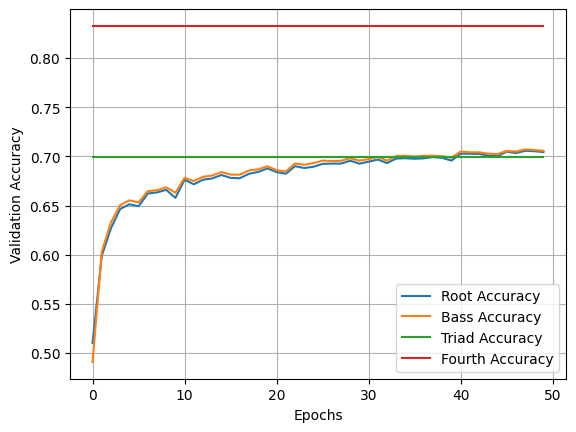

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# File to store accuracies
accuracy_file = 'Outputs/accuracies.txt'

# Initialize model save path
model_save_path = "accordo_ai_model.keras"

# Initialize batch size
batch_size = 64  # Batch size

# Function to load the best accuracies from the file
def load_best_accuracies():
    try:
        with open(accuracy_file, 'r') as file:
            lines = file.readlines()
            best_accuracies = {
                'root': float(lines[0].strip()),
                'bass': float(lines[1].strip()),
                'triad': float(lines[2].strip()),
                'fourth': float(lines[3].strip())
            }
        return best_accuracies
    except FileNotFoundError:
        # If file doesn't exist, return default values
        return {'root': 0.0, 'bass': 0.0, 'triad': 0.0, 'fourth': 0.0}

# Function to save the best accuracies to the file
def save_best_accuracies(accuracies):
    with open(accuracy_file, 'w') as file:
        file.write(f"{accuracies['root']}\n")
        file.write(f"{accuracies['bass']}\n")
        file.write(f"{accuracies['triad']}\n")
        file.write(f"{accuracies['fourth']}\n")

# Load previous best accuracies
best_accuracies = load_best_accuracies()

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_data_reshaped, 
    {"root_output": y_root_train_final, 
     "bass_output": y_bass_train_final, 
     "triad_output": y_triad_train_final, 
     "fourth_output": y_fourth_train_final,
     "chord_class_output": y_chord_train_final},
    validation_data=(X_val_data_reshaped, 
                     {"root_output": y_root_val_final, 
                      "bass_output": y_bass_val_final, 
                      "triad_output": y_triad_val_final, 
                      "fourth_output": y_fourth_val_final,
                      "chord_class_output": y_chord_val_final}),
    epochs=50,  # Maximum number of epochs
    batch_size=batch_size, 
    verbose=1, 
    callbacks=[early_stopping, lr_callback]
)

# Get the best epoch
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
print(f"\n\nHighest accuracy achieved at epoch: {best_epoch}")

# Evaluate the model on the test data
test_result = model.evaluate(
    X_test_data_reshaped, 
    {"root_output": y_root_test_final, 
     "bass_output": y_bass_test_final, 
     "triad_output": y_triad_test_final, 
     "fourth_output": y_fourth_test_final,
     "chord_class_output": y_chord_test_final},
)


test_root_acc = test_result[1] * 100
test_bass_acc = test_result[2] * 100
test_triad_acc = test_result[3] * 100
test_fourth_acc = test_result[4] * 100
test_chord_acc = test_result[5] * 100

print(f"\n\nTest Accuracy - Root: {test_root_acc:.2f}%, Bass: {test_bass_acc:.2f}%, Triad: {test_triad_acc:.2f}%, Fourth: {test_fourth_acc:.2f}%, Chord: {test_chord_acc:.2f}%")

# Compare and save the best accuracies
update_needed = False
if test_root_acc > best_accuracies['root']:
    best_accuracies['root'] = test_root_acc
    update_needed = True

if test_bass_acc > best_accuracies['bass']:
    best_accuracies['bass'] = test_bass_acc
    update_needed = True

if test_triad_acc > best_accuracies['triad']:
    best_accuracies['triad'] = test_triad_acc
    update_needed = True

if test_fourth_acc > best_accuracies['fourth']:
    best_accuracies['fourth'] = test_fourth_acc
    update_needed = True

# # If accuracy improved, save the model and update the file
# if update_needed:
#     model.save(model_save_path)
#     print("Model saved! New best accuracy recorded.")
#     save_best_accuracies(best_accuracies)

# Plot the accuracy curve
plt.plot(history.history['val_root_output_accuracy'], label='Root Accuracy')
plt.plot(history.history['val_bass_output_accuracy'], label='Bass Accuracy')
plt.plot(history.history['val_triad_output_accuracy'], label='Triad Accuracy')
plt.plot(history.history['val_fourth_output_accuracy'], label='Fourth Accuracy')
plt.plot(history.history['val_chord_class_output_accuracy'], label='Chord Accuracy')
plt.title('Model Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# model.save(model_save_path)
# print("Model saved! New best accuracy recorded.")

Model saved! New best accuracy recorded.
